# Univariate Analysis

In [525]:
import csv
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Import Data

In [526]:
csv_files = glob.glob('*.csv')
dfs = []

for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Display Data Information

In [527]:
df.info() # no missing values (1,000,000 values expected)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   factory_id            999999 non-null  int64  
 1   tag_type_code         999999 non-null  int64  
 2   battery_replace_date  999999 non-null  object 
 3   display_name          999999 non-null  object 
 4   wdt_state_id          999999 non-null  int64  
 5   sensor_value          999999 non-null  int64  
 6   voltage               999999 non-null  float64
 7   battery_capacity      999999 non-null  float64
 8   base_capacity         999999 non-null  float64
 9   wakeup_counter        999999 non-null  int64  
 10  firmware_version      999999 non-null  int64  
 11  read_date             999999 non-null  object 
 12  render_counter        999999 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 99.2+ MB


# Factory ID

In [528]:
# Factory ID is more categorical than numerical, so we find how many unique IDs as well as well as their counts
factory_unique = df['factory_id'].unique()
print('Unique Factory IDs:', len(factory_unique))

factory_counts = df['factory_id'].value_counts()
print('Unique Factory ID Counts:', factory_counts)

Unique Factory IDs: 10996
Unique Factory ID Counts: factory_id
72561069    120
72550335    120
72554802    120
72552537    120
72554691    120
           ... 
72558765      1
72235152      1
72557858      1
72557856      1
72596742      1
Name: count, Length: 10996, dtype: int64


# Tag Type Code

In [529]:
# Similar to factory ID, categorical. Contains only 1 unique value.
ttc_unique = df['tag_type_code'].unique()
print('Unique Tag Type Codes:', len(ttc_unique))

ttc_counts = df['tag_type_code'].value_counts()
print('Unique Factory ID Counts:', ttc_counts)

Unique Tag Type Codes: 1
Unique Factory ID Counts: tag_type_code
208    999999
Name: count, dtype: int64


# Battery Replacement Date

In [530]:
# Turn the dates from object to datetime
df['read_date'] = df['read_date'].str.replace(r'\.\d+$', '', regex=True)
df['battery_replace_date'] = df['battery_replace_date'].str.replace(r'\.\d+$', '', regex=True)

df['battery_replace_date'] = pd.to_datetime(df['battery_replace_date'])
df['read_date'] = pd.to_datetime(df['read_date'])

# Confirm data types
df.dtypes

factory_id                       int64
tag_type_code                    int64
battery_replace_date    datetime64[ns]
display_name                    object
wdt_state_id                     int64
sensor_value                     int64
voltage                        float64
battery_capacity               float64
base_capacity                  float64
wakeup_counter                   int64
firmware_version                 int64
read_date               datetime64[ns]
render_counter                   int64
dtype: object

In [531]:
# Dates at which the battery was last replaced
battery_replace_date = df['battery_replace_date']
print('Battery Replacement Date Range:', battery_replace_date.min(), 'to', battery_replace_date.max())

battery_replace_date_counts = df['battery_replace_date'].value_counts()
print(battery_replace_date_counts, '\n')

# It appears there are some nonsensical dates, we must drop them. Get the top 10 most recent dates
top_10_dates = battery_replace_date.nlargest(10)
print('Most recent dates:')
print(top_10_dates)

Battery Replacement Date Range: 2007-12-26 00:00:00 to 2135-05-16 01:00:00
battery_replace_date
2018-03-27 01:00:00    340631
2018-03-26 01:00:00    238643
2018-05-16 01:00:00    191533
2018-03-28 01:00:00     92331
2018-05-21 01:00:00     31386
                        ...  
2018-05-22 15:57:02         1
2018-06-07 09:13:47         1
2018-06-07 09:47:51         1
2018-05-28 08:19:46         1
2018-06-07 14:44:03         1
Name: count, Length: 104, dtype: int64 

Most recent dates:
250360   2135-05-16 01:00:00
672549   2062-12-01 00:00:00
9930     2049-11-10 00:00:00
42155    2049-11-10 00:00:00
355699   2049-11-10 00:00:00
986970   2018-12-29 11:19:42
986971   2018-12-29 11:19:42
986972   2018-12-29 11:19:42
791663   2018-12-18 13:10:04
791664   2018-12-18 13:10:04
Name: battery_replace_date, dtype: datetime64[ns]


In [532]:
# Drop all dates past December 31, 2018, then check range again.
dates_filtered = df[battery_replace_date <= '2018-12-31']

# Display the min and max of the filtered 'battery_replace_date'
battery_replace_date = dates_filtered['battery_replace_date'].dropna()
print('Battery Replacement Date Range:', battery_replace_date.min(), 'to', battery_replace_date.max())

Battery Replacement Date Range: 2007-12-26 00:00:00 to 2018-12-29 11:19:42


In [533]:
# Find how many times the battery is replaced
battery_replace_counts = len(battery_replace_date.unique())
print('Battery Replacement Counts:', battery_replace_counts)

# Average Time between battery replacements
unique_dates = battery_replace_date.drop_duplicates().sort_values()
print(unique_dates)

Battery Replacement Counts: 101
5468     2007-12-26 00:00:00
17617    2008-01-08 00:00:00
18849    2008-01-10 00:00:00
21390    2008-01-12 00:00:00
35933    2008-01-13 00:00:00
                 ...        
724993   2018-07-06 13:43:29
961741   2018-07-07 15:41:54
258521   2018-12-14 00:00:00
791663   2018-12-18 13:10:04
986970   2018-12-29 11:19:42
Name: battery_replace_date, Length: 101, dtype: datetime64[ns]


In [534]:
# Calculate the difference between consecutive dates
time_diff = unique_dates.diff().dropna()

# Display statistics of battery placements
time_diff.describe()

count                            100
mean         40 days 05:09:11.820000
std      354 days 01:20:50.579899540
min                  0 days 00:00:07
25%           0 days 00:45:51.250000
50%                  1 days 00:00:00
75%                  2 days 00:00:00
max               3541 days 01:00:00
Name: battery_replace_date, dtype: object

# Display Name

In [535]:
# Only 1 unique display name
display_unique = df['display_name'].unique()
print('Unique Display Names:', len(display_unique))

display_counts = df['display_name'].value_counts()
print('Unique Display Name Counts:', display_counts)

Unique Display Names: 1
Unique Display Name Counts: display_name
eTag150E2    999999
Name: count, dtype: int64


# WDT State ID

In [536]:
# 2 unique states, could indicate on or off
x = 755437/999999
y = 244562/999999

wdt_unique = df['wdt_state_id'].unique()
print('Unique WTD State IDs:', len(wdt_unique))

wdt_counts = df['wdt_state_id'].value_counts()
print('Unique WTD State ID Counts:', wdt_counts)

# WDT State ID Proportions
print(f'\nProportion of WDT State ID of 3: {x:.4f}')
print(f'Proportion of WDT State ID of 1: {y:.4f}')

Unique WTD State IDs: 2
Unique WTD State ID Counts: wdt_state_id
3    755437
1    244562
Name: count, dtype: int64

Proportion of WDT State ID of 3: 0.7554
Proportion of WDT State ID of 1: 0.2446


# Sensor Value

In [537]:
# numerical column, looks normally distrubuted
sensor_value = df['sensor_value']
sensor_value.describe()

count    999999.000000
mean        181.211208
std           4.751103
min          64.000000
25%         181.000000
50%         182.000000
75%         183.000000
max         255.000000
Name: sensor_value, dtype: float64

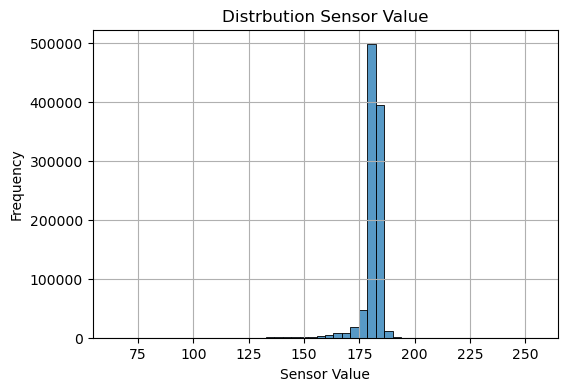

In [538]:
# histogram
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x=sensor_value, bins=50)
plt.title('Distrbution Sensor Value')
plt.xlabel('Sensor Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Voltage

In [539]:
# numerical column, looks normally distributed
voltage = df['voltage']
voltage.describe()

count    999999.000000
mean          2.966106
std           0.078868
min           1.020400
25%           2.962600
50%           2.979200
75%           2.995800
max           4.191000
Name: voltage, dtype: float64

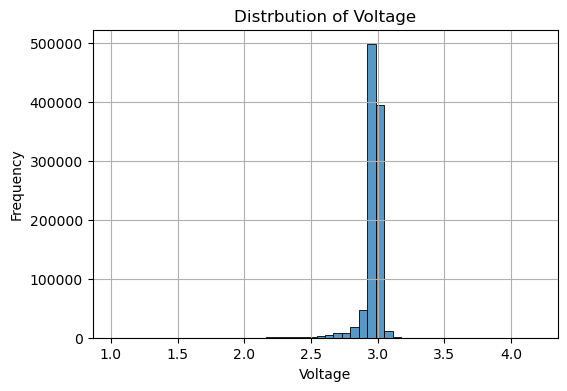

In [540]:
# histogram
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x=voltage, bins=50)
plt.title('Distrbution of Voltage')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Battery Capacity

In [541]:
# numerical column, looks normally distributed
df['battery_capacity'].describe()

count    999999.000000
mean         65.802486
std          18.354133
min           0.000000
25%          52.400000
50%          67.500000
75%          80.600000
max        2474.600000
Name: battery_capacity, dtype: float64

In [542]:
# There are some anomalous values, let us drop them with the assumption 100 is the max battery capacity, and check
df.drop(df[df['battery_capacity'] >= 100].index, inplace=True)
df['battery_capacity'].describe()

count    999994.000000
mean         65.797179
std          18.136711
min           0.000000
25%          52.400000
50%          67.500000
75%          80.600000
max          98.300000
Name: battery_capacity, dtype: float64

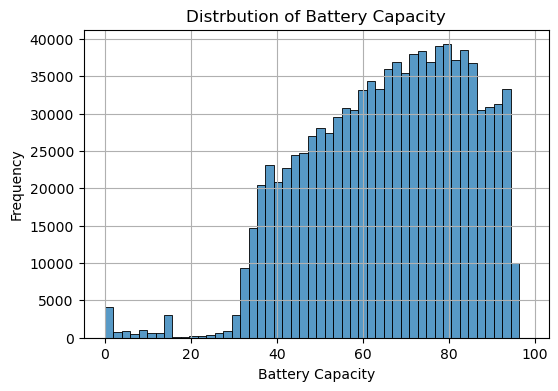

In [543]:
# After cleaning, plot histogram
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x=df['battery_capacity'], bins=50)
plt.title('Distrbution of Battery Capacity')
plt.xlabel('Battery Capacity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Base Capacity

In [544]:
# numerical column, base capacity has exact same values as battery capacity, can ignore
df['base_capacity'].describe()

count    999994.000000
mean         65.797179
std          18.136711
min           0.000000
25%          52.400000
50%          67.500000
75%          80.600000
max          98.300000
Name: base_capacity, dtype: float64

# Wakeup Counter

In [545]:
# This variable appears to label the amount of time that has passed since the previous wakeup call.
# It acts as a running marker for this feature, so we must take statistics based on each total session.
# We will reverse the column and mark when the number decreases to mark the end of 1 session.
df['wakeup_counter']

0         726797
1         703520
2         679991
3         654601
4         622145
           ...  
999994    422619
999995    399038
999996    376355
999997    352497
999998    329758
Name: wakeup_counter, Length: 999994, dtype: int64

In [546]:
# Reverse the column
df['wakeup_counter'] = np.flip(df['wakeup_counter'].values)

In [547]:
df['wakeup_counter']

0         329758
1         352497
2         376355
3         399038
4         422619
           ...  
999994    622145
999995    654601
999996    679991
999997    703520
999998    726797
Name: wakeup_counter, Length: 999994, dtype: int64

In [548]:
# Create a column that identifies when a session ends (when a number decreases)
df['session_end'] = df['wakeup_counter'].diff().lt(0)
df['session_end']

# Filter the dataframe to find when session_end is True
session_end_true = df[df['session_end'] == True]

# Print amount of sessions
print('Amount of sessions:', len(session_end_true))

Amount of sessions: 14898


In [549]:
# Create a session ID based on when the session ends
df['session'] = df['session_end'].cumsum()
df['session']

0             0
1             0
2             0
3             0
4             0
          ...  
999994    14898
999995    14898
999996    14898
999997    14898
999998    14898
Name: session, Length: 999994, dtype: int32

In [550]:
# Drop the 'session_end' column
df = df.drop(columns='session_end')

In [551]:
# Group by the 'session' column and calculate the min and max for each session
session_min_max = df.groupby('session')['wakeup_counter'].agg(['min', 'max'])

# Display the result
print(session_min_max)

            min       max
session                  
0        329758   1493071
1         22610    262317
2         15526   2208799
3         22311   2275734
4         16305    611250
...         ...       ...
14894    316539  11404318
14895     22226   1975236
14896     22212    656727
14897     19916   2808148
14898    313056    726797

[14899 rows x 2 columns]


In [552]:
# Sort the sessions by the 'max' value in descending order and select the top 100
top_sessions = session_min_max.sort_values(by='max', ascending=False).head(20)

# Print the top sessions with their min and max values
print(top_sessions)

            min         max
session                    
6687      89375  4294967295
12551     13602  4015062186
3885      21185  3135259112
14211    248574  3054266768
10609      9703  3036871261
13358     57041  2181577510
9219      13435  1074896900
11239     10064  1074896900
3923      10118  1074896900
4016      11987  1074896900
5903      31409  1074896900
7969      15819   738208087
5234       7187   525998504
8933      10623   316015528
14529      9900   142988720
484       11627    74067170
6001      44645    32940574
14456     12887    30036098
4763      48513    24311082
1944      14106    23923026


In [553]:
# It is very difficult to determine which values of wakeup counter are extraneous, so we implement some measures 
# to call out when the interval between two numbers when increasing is more than a factor of 10.
# Furthermore, we only check for numbers that are 6 or more digits, as going from 5 to 6 digits is still plausible.
# We then check the interval between the jumped number and the next to determine if it is a plausible reading or a mistake.

# Initialize list to store results
jumped_values = []

# Iterate through the dataframe to check for jumps greater than 10 times in increasing values
for i in range(1, len(df)-1):  # len(df)-1 to avoid IndexError when checking the next value
    # Check if the current value is more than 10 times the previous value
    if df['wakeup_counter'].iloc[i] > 10 * df['wakeup_counter'].iloc[i-1]:
        # Only consider the jump when the value is increasing and the previous value has 6 digits
        if df['wakeup_counter'].iloc[i] > df['wakeup_counter'].iloc[i-1] and len(str(df['wakeup_counter'].iloc[i-1])) >= 6:
            session_number = df['session'].iloc[i]
            previous_value = df['wakeup_counter'].iloc[i-1]
            current_value = df['wakeup_counter'].iloc[i]
            
            # Calculate the interval (difference) between the previous value and the current jumped value
            interval = current_value / previous_value

            # Get the next value (after the jumped value)
            next_value = df['wakeup_counter'].iloc[i+1]

            # Check if the next value increases
            if next_value > current_value:
                magnitude_increase = next_value / current_value  # Calculate the magnitude of increase
                jumped_values.append((session_number, previous_value, current_value, interval, next_value, magnitude_increase))
            else:
                jumped_values.append((session_number, previous_value, current_value, interval, None, None))

# Create a DataFrame from the results for better readability
jumped_values_df = pd.DataFrame(jumped_values, columns=["Session", "Previous Value", "Jumped Value", "Interval", "Next Value", "Magnitude of Increase"])

# Print the results neatly in a table
print(jumped_values_df)

     Session  Previous Value  Jumped Value   Interval  Next Value  \
0         15          358395      17429444  48.631940         NaN   
1        152          552801       7838204  14.179070   8011353.0   
2        302          108083       1097718  10.156250   1212964.0   
3        484         2770232      74067170  26.736811         NaN   
4        767          331893       4730739  14.253808   4756281.0   
..       ...             ...           ...        ...         ...   
176    14685          336781      10237584  30.398342  10261207.0   
177    14692          414063       4917634  11.876536   4943441.0   
178    14712          971170       9828509  10.120277   9876464.0   
179    14727          721318       7947515  11.018046   7969996.0   
180    14894          316539       6436074  20.332641   6865878.0   

     Magnitude of Increase  
0                      NaN  
1                 1.022090  
2                 1.104987  
3                      NaN  
4                 1.005399

# Filtering out likely extraneous values from Wakeup Counter

1. Find the values that only jump with a magnitude of 10 amongst 6 digit numbers that do not have a following number.

In [554]:
# check which sessions have a next value of NaN to show that it is likely not a mistake
jumped_values_df_nan = jumped_values_df[jumped_values_df["Next Value"].isna()]

# sort by interval to check how anomalous they are
jumped_values_df_nan_sorted = jumped_values_df_nan.sort_values(by="Interval", ascending=False)

# these values are all likely to be mistakes, we will judge which values are to be dropped or kept
print(jumped_values_df_nan_sorted)

# we will likely drop all values here

     Session  Previous Value  Jumped Value     Interval  Next Value  \
92      9219          140000    1074896900  7677.835000         NaN   
122    11239          150775    1074896900  7129.145415         NaN   
27      3923          207065    1074896900  5191.108589         NaN   
51      5234          201473     525998504  2610.764241         NaN   
67      6687         1666550    4294967295  2577.160778         NaN   
144    12551         1630726    4015062186  2462.131705         NaN   
87      8933          145635     316015528  2169.914705         NaN   
114    10609         1659728    3036871261  1829.740332         NaN   
170    14211         3019969    3054266768  1011.356993         NaN   
26      3885         3415010    3135259112   918.081971         NaN   
175    14529          283416     142988720   504.518870         NaN   
55      5903         2811769    1074896900   382.284925         NaN   
73      7969         2968469     738208087   248.683105         NaN   
0     

In [555]:
# Get the list of "Jumped Value" to drop
values_to_drop = jumped_values_df_nan_sorted["Jumped Value"].tolist()
print(values_to_drop)

[1074896900, 1074896900, 1074896900, 525998504, 4294967295, 4015062186, 316015528, 3036871261, 3054266768, 3135259112, 142988720, 1074896900, 738208087, 17429444, 4283686, 32940574, 74067170, 4044908, 9080125, 14120256, 6561676, 2942552]


In [556]:
# Drop the rows from the original DataFrame where wakeup_counter matches any of the jumped values
df = df[~df['wakeup_counter'].isin(values_to_drop)]

# Print the cleaned DataFrame
print(df)

        factory_id  tag_type_code battery_replace_date display_name  \
0           196608            208  2018-03-28 01:00:00    eTag150E2   
1           196608            208  2018-03-28 01:00:00    eTag150E2   
2           196608            208  2018-03-28 01:00:00    eTag150E2   
3         71269681            208  2017-11-09 00:00:00    eTag150E2   
4         71269681            208  2017-11-09 00:00:00    eTag150E2   
...            ...            ...                  ...          ...   
999994    72638481            208  2018-05-19 01:00:00    eTag150E2   
999995    72638481            208  2018-05-19 01:00:00    eTag150E2   
999996    72638481            208  2018-05-19 01:00:00    eTag150E2   
999997    72638481            208  2018-05-19 01:00:00    eTag150E2   
999998    72638481            208  2018-05-19 01:00:00    eTag150E2   

        wdt_state_id  sensor_value  voltage  battery_capacity  base_capacity  \
0                  1           184   3.0124              84.4      

In [557]:
df['wakeup_counter'].max()

2181577510

2. Find all values where there exists a next value but sort by interval between one value and the 10x jumped value to find if the anomalous number continues to be anomalous.

In [558]:
# find numbers where next value is not NaN
jumped_values_df_non_nan = jumped_values_df[jumped_values_df["Next Value"].notna()]

# sort by interval to find anomalous jumped values
jumped_values_df_non_nan_sorted = jumped_values_df_non_nan.sort_values(by="Interval", ascending=False)

# it appears that only session 13358 contains continued anomalous numbers
print(jumped_values_df_non_nan_sorted)

# we will likely only drop the value from session 13358, as its jumped value is too large to be plausible
session_number = 13358
session_values = df[df['session'] == session_number]['wakeup_counter']

# Print the values
for i in session_values:
    print(i)

     Session  Previous Value  Jumped Value     Interval    Next Value  \
154    13358         1775930    2181065498  1228.125826  2.181088e+09   
172    14401          128306       6456964    50.324724  6.485787e+06   
119    11027          266064      12209285    45.888527  1.223378e+07   
174    14456          788430      29549686    37.479150  2.957698e+07   
168    14154          267325       9568562    35.793742  9.591411e+06   
..       ...             ...           ...          ...           ...   
59      6091          384714       3905335    10.151268  3.928585e+06   
22      2682          370438       3751954    10.128426  3.775003e+06   
178    14712          971170       9828509    10.120277  9.876464e+06   
139    12374          200606       2022143    10.080172  2.047426e+06   
30      4113          248185       2498841    10.068461  2.672008e+06   

     Magnitude of Increase  
154               1.000010  
172               1.004464  
119               1.002006  
174    

In [559]:
# Identify the jumped value and its index in session 13358
jumped_value_13358 = jumped_values_df_non_nan_sorted.loc[jumped_values_df_non_nan_sorted['Session'] == 13358, 'Jumped Value'].iloc[0]

# Get the index of the first jumped value in session 13358
start_index = df[(df['session'] == 13358) & (df['wakeup_counter'] == jumped_value_13358)].index[0]

# Find the index of the next session (to determine where session 13358 ends)
next_session_index = df[df['session'] > 13358].index.min()

# Drop the range of rows from the DataFrame
if next_session_index:
    df = df.drop(index=range(start_index, next_session_index))
else:
    df = df.drop(index=range(start_index, len(df)))  # Drop till the end if no next session

# Print the cleaned DataFrame
print(df)

        factory_id  tag_type_code battery_replace_date display_name  \
0           196608            208  2018-03-28 01:00:00    eTag150E2   
1           196608            208  2018-03-28 01:00:00    eTag150E2   
2           196608            208  2018-03-28 01:00:00    eTag150E2   
3         71269681            208  2017-11-09 00:00:00    eTag150E2   
4         71269681            208  2017-11-09 00:00:00    eTag150E2   
...            ...            ...                  ...          ...   
999994    72638481            208  2018-05-19 01:00:00    eTag150E2   
999995    72638481            208  2018-05-19 01:00:00    eTag150E2   
999996    72638481            208  2018-05-19 01:00:00    eTag150E2   
999997    72638481            208  2018-05-19 01:00:00    eTag150E2   
999998    72638481            208  2018-05-19 01:00:00    eTag150E2   

        wdt_state_id  sensor_value  voltage  battery_capacity  base_capacity  \
0                  1           184   3.0124              84.4      

In [560]:
df['wakeup_counter'].max()

30036098

Visualize anomalous sessions

3. Check the magnitude of the the jumped number and the following numbers to ensure they are consistent to denote plausibility

In [561]:
# Sort by magnitude of increase where next value is not NaN, ordered from largest to smallest
jumped_values_df_non_nan_sorted_by_magnitude = jumped_values_df_non_nan_sorted.sort_values(by="Magnitude of Increase", ascending=False)

# Print the results
print(jumped_values_df_non_nan_sorted_by_magnitude)

# We can see that the magnitude of increase is not anomalous amongst the values that
# have a next value, so none of the values here will be dropped.

     Session  Previous Value  Jumped Value     Interval    Next Value  \
151    13006          338643       4302179    12.704172  7.173942e+06   
7       1134          178274       2200036    12.340756  3.619663e+06   
10      1560          368734       5357243    14.528747  7.648416e+06   
158    13749          243933       4730356    19.392030  5.421644e+06   
2        302          108083       1097718    10.156250  1.212964e+06   
..       ...             ...           ...          ...           ...   
132    12020         1044097      19844163    19.006053  1.986899e+07   
40      4763         1133011      24285387    21.434379  2.431108e+07   
14      2341          307247       5665090    18.438227  5.670951e+06   
174    14456          788430      29549686    37.479150  2.957698e+07   
154    13358         1775930    2181065498  1228.125826  2.181088e+09   

     Magnitude of Increase  
151               1.667514  
7                 1.645274  
10                1.427678  
158    

In [562]:
# Since we dropped most of the anomalous values, we will recategorize the wakeup_counter sessions and analyze it.
df['wakeup_counter'].dropna()

0         329758
1         352497
2         376355
3         399038
4         422619
           ...  
999994    622145
999995    654601
999996    679991
999997    703520
999998    726797
Name: wakeup_counter, Length: 999890, dtype: int64

In [563]:
# Create a column that identifies when a session ends (when a number decreases)
df['session_end'] = df['wakeup_counter'].diff().lt(0)
df['session_end']

# Filter the dataframe to find when session_end is True
session_end_true = df[df['session_end'] == True]

# Print amount of sessions
print('Amount of sessions:', len(session_end_true))

Amount of sessions: 14885


In [564]:
# Create a session ID based on when the session ends
df['session'] = df['session_end'].cumsum()
df['session']

0             0
1             0
2             0
3             0
4             0
          ...  
999994    14885
999995    14885
999996    14885
999997    14885
999998    14885
Name: session, Length: 999890, dtype: int32

In [565]:
# Drop 'session_end' column and reset the index
df = df.drop(columns='session_end')

In [566]:
# Group by the 'session' column and calculate the min and max for each session
session_min_max = df.groupby('session')['wakeup_counter'].agg(['min', 'max'])

# Display the result
print(session_min_max)

            min       max
session                  
0        329758   1493071
1         22610    262317
2         15526   2208799
3         22311   2275734
4         16305    611250
...         ...       ...
14881    316539  11404318
14882     22226   1975236
14883     22212    656727
14884     19916   2808148
14885    313056    726797

[14886 rows x 2 columns]


In [567]:
# Sort the sessions by the 'max' value in descending order and select the top 20
top_sessions = session_min_max.sort_values(by='max', ascending=False).head(20)

# Print the top sessions with their min and max values
print(top_sessions)

# the wakeup_counter may refer to a time unit, but we lack information just from this variable alone

            min       max
session                  
14444     12887  30036098
4761      48513  24311082
1943      14106  23923026
14009     10458  21690020
6872      14138  20674674
12010      7457  20353550
10598     15199  19897071
9975      42259  19373926
13066     36674  19185992
8105       8735  19135970
7850     123030  18317115
1084      14032  17833622
8048      44428  17028841
13986     17122  16697712
8673       7399  16493716
4577      19427  16167821
5262      19385  16027740
10035     10044  15837768
3879     152326  15324195
6630     187856  15293279


# Firmware Version

In [606]:
# also more categorical
firmware = df['firmware_version'].unique()
print('Unique Firmware Versions:', len(firmware))

# how many times each firmware version had readings
print(df['firmware_version'].value_counts())

Unique Firmware Versions: 16
firmware_version
26            988839
24              6022
0               2398
1107            1543
21               162
1515870810       126
83887187         121
55               114
23               113
1108             111
1101              92
1025              62
15                55
1115              55
83887188          43
85                34
Name: count, dtype: int64


# Read Date

In [608]:
# the time the data entry was initialized
read_date = df['read_date']
print('Read Date Range:', read_date.min(), 'to', read_date.max())

# we can take each session as found in the wakeup_counter section and examine the read dates of each session
# since the wake_up counters and session features are reversed, we much reverse read date too
df['read_date'] = np.flip(df['read_date'].values)
df['read_date']

Read Date Range: 2018-06-12 12:01:08 to 2021-02-04 12:09:04
       session        date_range
9743      9743 964 days 00:01:50
4315      4315 963 days 23:59:33
5350      5350 963 days 23:59:10
4766      4766 963 days 23:55:44
4195      4195 962 days 23:58:39
...        ...               ...
13117    13117   0 days 00:00:00
8607      8607   0 days 00:00:00
6028      6028   0 days 00:00:00
1539      1539   0 days 00:00:00
5600      5600   0 days 00:00:00

[14886 rows x 2 columns]


In [637]:
# session 0 read dates
session_0_dates = df[df['session'] == 13358]['read_date'].head(10)
print(session_0_dates)

# We see that intervals between read dates of session 0 vary by days at a time.
# After some inspection of the data, there are some anomalies with read date as well
# where some read dates are beyond the scope of the more common read dates.
# I'm not quite sure how to fix that.

900400   2018-07-16 12:01:28
900401   2018-07-24 12:01:37
900402   2018-08-01 12:01:56
900403   2018-08-09 12:01:10
900404   2018-08-17 12:02:57
900405   2018-08-25 12:01:54
900406   2018-09-10 12:04:53
900407   2018-09-18 12:01:02
900408   2018-09-26 12:03:21
900409   2018-10-04 12:01:46
Name: read_date, dtype: datetime64[ns]


# Render Counter

In [641]:
# Render Counter is also unique in the way that it is similar to wakeup counter.
# Therefore, we can apply a similar approach.
df['render_counter']

0         21
1         21
2         21
3         84
4         84
          ..
999994     7
999995     7
999996     7
999997     6
999998     6
Name: render_counter, Length: 999890, dtype: int64

In [642]:
# reverse render counter to match with wakeup counter and the sessions
df['render_counter'] = np.flip(df['render_counter'].values)
df['render_counter']

0          6
1          6
2          7
3          7
4          7
          ..
999994    84
999995    84
999996    21
999997    21
999998    21
Name: render_counter, Length: 999890, dtype: int64

In [651]:
render_counter = df['render_counter']
render_range = render_counter.max() - render_counter.min() 
print('Render Counter Range:', render_range)

# The range seems to output some anomalous numbers, so we must clean it.
render_counter.nlargest(150).unique()

Render Counter Range: 4294967295


array([4294967295, 4292893274, 4292870225, 4292870200, 4292870184,
       4292870167, 4292870164, 4292870160, 4292870149, 3105593063,
       1515870810, 1075843076,  315753387,   83886122,   83886121,
         83886116,   83886111,   83886109,   83886108,   83886104,
         83886103,   83886100,   67698917,   16711887,   16711885,
          1114166,      46586,      33837,      21056,       1624,
              731,        730], dtype=int64)

In [ ]:
# Here I notice that each session should actually be defined when both wakeup counter and render counter reset
# so later, I will align the sessions to be counted in such a way. 

In [660]:
# Find the top 100 render counter values
top_100_render_counter = df.nlargest(100, 'render_counter')

# Get the unique sessions corresponding to these top render counter values
top_100_sessions = top_100_render_counter['session'].unique()

# Display the sessions and the corresponding render counter values
print(top_100_render_counter[['session', 'render_counter']])

        session  render_counter
41307       555      4294967295
41308       555      4294967295
41309       555      4294967295
41310       555      4294967295
41311       555      4294967295
...         ...             ...
443337     6128        83886122
443338     6128        83886122
443339     6128        83886122
443340     6128        83886122
443341     6128        83886122

[100 rows x 2 columns]


In [661]:
# Let us examine session 555
render_counter_session_555 = df[df['session'] == 555][['render_counter', 'wakeup_counter', 'read_date', 'battery_capacity']]
print(render_counter_session_555)

# Here we see an error in wakeup_counter, where the increase in wakeup counter marked this as 1 continuous session
# where in reality, the session actually ended and the next session started with a larger wakeup counter, further
# necessitating the fact that render counter must sync with wakeup counter.
# And of course, the anomalous values are very obvious here.

       render_counter  wakeup_counter           read_date  battery_capacity
41284               6           19774 2021-02-02 12:01:47              36.9
41285               4           42626 2019-04-18 12:02:25              81.5
41286               4          102172 2019-04-26 12:02:55              81.0
41287              10          129773 2019-05-12 12:02:18              79.9
41288              11          167460 2019-05-20 12:02:53              79.4
41289              11          197500 2019-05-28 12:02:29              78.8
41290              11          257112 2019-06-05 12:02:48              78.3
41291              13          284989 2019-06-23 12:02:05              77.1
41292              15          312210 2019-07-01 12:02:29              76.6
41293              16          339011 2019-07-09 12:03:54              76.0
41294              16          364053 2019-07-17 12:02:06              75.5
41295              16          388875 2019-07-25 12:02:23              75.0
41296       

In [ ]:
# Fix the session organization to when wakeup counter and render counter both change.
# Clean both accordingly.

(fin)

# lazy analysis

In [589]:
# from here, I realize the wakeup counter may be monitoring the amount of milliseconds

# Divide every value in the wakeup_counter column by 60
df['minutes'] = df['wakeup_counter'] / 60 # assuming seconds to minutes
df['minutes']

0          5495.966667
1          5874.950000
2          6272.583333
3          6650.633333
4          7043.650000
              ...     
999994    10369.083333
999995    10910.016667
999996    11333.183333
999997    11725.333333
999998    12113.283333
Name: minutes, Length: 999890, dtype: float64

In [591]:
df['hours'] = df['minutes'] / 60 # minutes to hours
df['days'] = df['hours'] / 24 # hours to days
df['weeks'] = df['days'] / 7 # days to weeks
df['years'] = df['weeks'] / 52 # weeks to years

In [580]:
# reverse read date
df['read_date'] = np.flip(df['read_date'].values)
df['read_date']

0        2019-04-23 12:02:38
1        2019-05-01 12:02:30
2        2019-05-09 12:03:03
3        2019-05-17 12:03:16
4        2019-05-25 12:02:26
                 ...        
999994   2021-01-22 12:03:00
999995   2021-01-31 12:03:59
999996   2018-11-07 12:02:12
999997   2018-11-15 12:02:36
999998   2018-11-23 12:01:49
Name: read_date, Length: 999890, dtype: datetime64[ns]

In [ ]:
# reverse battery capacity
df['battery_capacity'] = np.flip(df['battery_capacity'].values)
df['battery_capacity']

In [599]:
# Filter the rows where session is 0 and display the desired columns
session_0_data = df[df['session'] == 0][['read_date', 'wakeup_counter', 'battery_capacity']]

# Display the filtered data for session 0
print(session_0_data)

             read_date  wakeup_counter  battery_capacity
0  2019-04-23 12:02:38          329758              80.1
1  2019-05-01 12:02:30          352497              79.6
2  2019-05-09 12:03:03          376355              79.1
3  2019-05-17 12:03:16          399038              78.6
4  2019-05-25 12:02:26          422619              78.0
5  2019-06-02 12:02:52          445984              77.5
6  2019-06-10 12:03:12          468203              77.0
7  2019-06-18 12:02:16          490953              76.5
8  2019-06-26 12:02:39          516308              13.1
9  2019-07-04 12:02:59          539060              75.5
10 2019-07-12 12:02:14          562742              75.0
11 2019-07-20 12:02:45          587061              74.4
12 2019-07-28 12:03:07          610519              73.9
13 2019-08-05 12:03:19          632855              73.4
14 2019-08-13 12:02:46          656735              72.9
15 2019-08-21 12:05:12          680700              72.4
16 2019-08-29 12:02:07         

In [600]:
# Filter the DataFrame for session 0
session_0_df = df[df['session'] == 0]

# Find the earliest and latest read_date
earliest_read_date = session_0_df['read_date'].min()
latest_read_date = session_0_df['read_date'].max()

# Find the difference in read_date (time difference)
read_date_diff = latest_read_date - earliest_read_date

# Find the smallest and largest wakeup_counter
smallest_wakeup_counter = session_0_df['wakeup_counter'].min()
largest_wakeup_counter = session_0_df['wakeup_counter'].max()

# Find the difference in wakeup_counter
wakeup_counter_diff = largest_wakeup_counter - smallest_wakeup_counter

# Print the results
print(f"Time difference in read_date (session 0): {read_date_diff}")
print(f"Difference in wakeup_counter (session 0): {wakeup_counter_diff}")


Time difference in read_date (session 0): 398 days 23:59:41
Difference in wakeup_counter (session 0): 1163313


In [572]:
df[['session', 'seconds', 'minutes', 'hours', 'days', 'weeks', 'years']]

,session,seconds,minutes,hours,days,weeks,years
0,0,329.758,5.495967,0.091599,0.003817,0.000545,0.000010
1,0,352.497,5.874950,0.097916,0.004080,0.000583,0.000011
2,0,376.355,6.272583,0.104543,0.004356,0.000622,0.000012
3,0,399.038,6.650633,0.110844,0.004618,0.000660,0.000013
4,0,422.619,7.043650,0.117394,0.004891,0.000699,0.000013
...,...,...,...,...,...,...,...
999994,14885,622.145,10.369083,0.172818,0.007201,0.001029,0.000020
999995,14885,654.601,10.910017,0.181834,0.007576,0.001082,0.000021
999996,14885,679.991,11.333183,0.188886,0.007870,0.001124,0.000022
999997,14885,703.520,11.725333,0.195422,0.008143,0.001163,0.000022


In [573]:
# Group by 'session' and sum the 'days' column
session_day_sum = df.groupby('session')['days'].sum()

# Display the result
print(session_day_sum)

session
0        0.537611
1        0.003298
2        1.114558
3        1.167713
4        0.087251
           ...   
14881    0.903208
14882    0.839685
14883    0.082643
14884    0.740019
14885    0.086264
Name: days, Length: 14886, dtype: float64


In [577]:
# Group by 'session' and aggregate the sum for each time measure
sessions_df = df.groupby('session')[['seconds', 'minutes', 'hours', 'days', 'weeks', 'years']].sum()

# make the session index start at 1 instead of 0
sessions_df.index = sessions_df.index + 1
print(sessions_df)

            seconds      minutes      hours      days     weeks     years
session                                                                  
1         46449.612   774.160200  12.902670  0.537611  0.076802  0.001477
2           284.927     4.748783   0.079146  0.003298  0.000471  0.000009
3         96297.782  1604.963033  26.749384  1.114558  0.159223  0.003062
4        100890.441  1681.507350  28.025122  1.167713  0.166816  0.003208
5          7538.485   125.641417   2.094024  0.087251  0.012464  0.000240
...             ...          ...        ...       ...       ...       ...
14882     78037.183  1300.619717  21.676995  0.903208  0.129030  0.002481
14883     72548.752  1209.145867  20.152431  0.839685  0.119955  0.002307
14884      7140.336   119.005600   1.983427  0.082643  0.011806  0.000227
14885     63937.627  1065.627117  17.760452  0.740019  0.105717  0.002033
14886      7453.207   124.220117   2.070335  0.086264  0.012323  0.000237

[14886 rows x 6 columns]


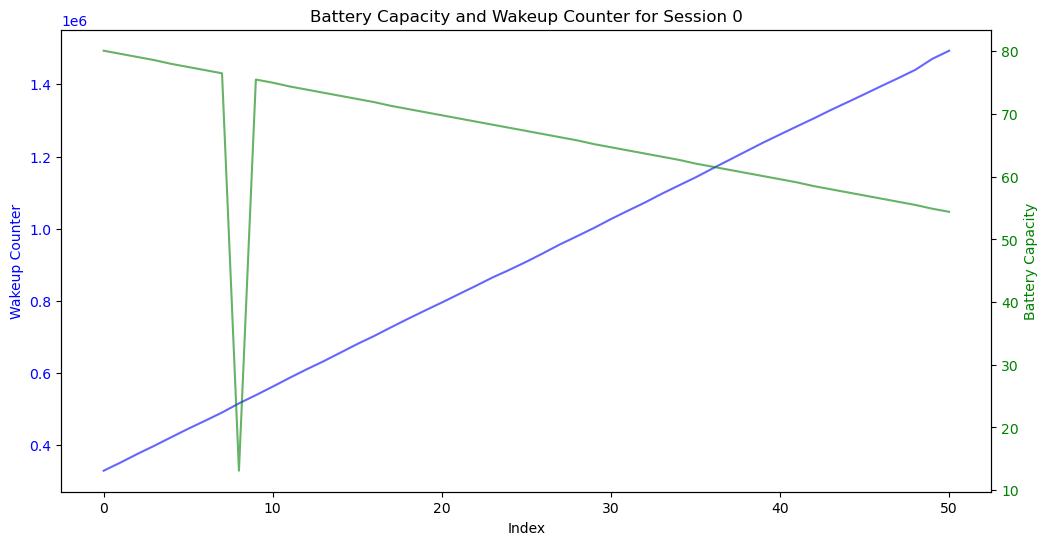

In [56]:
import matplotlib.pyplot as plt

# Filter data for session 0
session_0_data = df[df['session'] == 0]

# Plot battery_capacity and wakeup_counter
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot wakeup_counter on the first y-axis
ax1.plot(session_0_data.index, session_0_data['wakeup_counter'], color='b', label='Wakeup Counter', alpha=0.6)
ax1.set_xlabel('Index')
ax1.set_ylabel('Wakeup Counter', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot battery_capacity
ax2 = ax1.twinx()
ax2.plot(session_0_data.index, session_0_data['battery_capacity'], color='g', label='Battery Capacity', alpha=0.6)
ax2.set_ylabel('Battery Capacity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add title and show the plot
plt.title('Battery Capacity and Wakeup Counter for Session 0')
plt.show()


In [ ]:
# Group by the 'session' column and calculate the min and max for each session
session_min_max_filtered = df.groupby('session')['wakeup_counter'].agg(['min', 'max'])

# Sort the sessions by the max values in descending order and select the top 15
top_15_sessions = session_min_max_filtered.sort_values('max', ascending=False).head(15)

# Plot the min and max values
plt.figure(figsize=(10, 6))
plt.plot(session_min_max_filtered.index, session_min_max_filtered['min'], label='Min Value', color='blue', marker='o')
plt.plot(session_min_max_filtered.index, session_min_max_filtered['max'], label='Max Value', color='red', marker='o')

# Label the top 15 largest points (max values)
for session in top_15_sessions.index:
    max_value = session_min_max_filtered.loc[session, 'max']
    plt.text(session, max_value, f'Session {session}', fontsize=9, ha='right', color='darkred')

# Adding labels and title
plt.xlabel('Session')
plt.ylabel('Wakeup Counter Value')
plt.title('Min and Max Wakeup Counter Values per Session')

# Displaying the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
df.dtypes

factory_id                       int64
tag_type_code                    int64
battery_replace_date    datetime64[ns]
display_name                    object
wdt_state_id                     int64
sensor_value                     int64
voltage                        float64
battery_capacity               float64
base_capacity                  float64
wakeup_counter                   int64
firmware_version                 int64
read_date               datetime64[ns]
render_counter                   int64
session                          int32
dtype: object

In [ ]:
# render counter
render_unique = df['render_counter'].unique()
print('Unique Render Counter:', len(render))
render_counts = df['render_counter'].value_counts()

In [ ]:
# Generate Q-Q plot for 'render_counter'
stats.probplot(df['render_counter'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Render Counter")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

In [ ]:
# Box plot for 'render_counter'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['render_counter'])
plt.title("Box Plot for Render Counter")
plt.xlabel("Render Counter")
plt.grid(True)
plt.show()

In [ ]:
# Get unique values from 'render_counter', sort them, and get the top 50 largest
top_50_unique_values = df['render_counter'].drop_duplicates().nlargest(50)
print(top_50_unique_values)